<a href="https://colab.research.google.com/github/Janaki74/Fmmllab24/blob/main/FMML_M1L3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation

FMML Module 1, Lab 3

In this lab, we will see how augmentation of data samples help in improving the machine learning performance. Augmentation is the process of creating new data samples by making reasonable modifications to the original data samples. This is particularly useful when the size of the training data is small. We will use the MNISt dataset for this lab. We will also reuse functions from the previous labs.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp

rng = np.random.default_rng(seed=42)

In [ ]:
# loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# normalizing the data
train_X = train_X / 255
test_X = test_X / 255

# subsample from images and labels. Otherwise it will take too long!
train_X = train_X[::1200, :, :].copy()
train_y = train_y[::1200].copy()

11490434/11490434 [==============================] - 0s 0us/step


Let us borrow a few functions from the previous labs:

In [ ]:
def NN1(traindata, trainlabel, query):
    """
    This function takes in the training data, training labels and a query point
    and returns the predicted label for the query point using the nearest neighbour algorithm

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    query: numpy array of shape (d,) where d is the number of features

    returns: the predicted label for the query point which is the label of the training data which is closest to the query point
    """
    diff = (
        traindata - query
    )  # find the difference between features. Numpy automatically takes care of the size here
    sq = diff * diff  # square the differences
    dist = sq.sum(1)  # add up the squares
    label = trainlabel[np.argmin(dist)]
    return label


def NN(traindata, trainlabel, testdata):
    """
    This function takes in the training data, training labels and test data
    and returns the predicted labels for the test data using the nearest neighbour algorithm

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    testdata: numpy array of shape (m,d) where m is the number of test samples and d is the number of features

    returns: the predicted labels for the test data which is the label of the training data which is closest to each test point
    """
    traindata = traindata.reshape(-1, 28*28)
    testdata = testdata.reshape(-1, 28*28)
    predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
    return predlabel


def Accuracy(gtlabel, predlabel):
    """
    This function takes in the ground-truth labels and predicted labels
    and returns the accuracy of the classifier

    gtlabel: numpy array of shape (n,) where n is the number of samples
    predlabel: numpy array of shape (n,) where n is the number of samples

    returns: the accuracy of the classifier which is the number of correct predictions divided by the total number of predictions
    """
    assert len(gtlabel) == len(
        predlabel
    ), "Length of the ground-truth labels and predicted labels should be the same"
    correct = (
        gtlabel == predlabel
    ).sum()  # count the number of times the groundtruth label is equal to the predicted label.
    return correct / len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time. Let us first check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [ ]:
testpred = NN(train_X, train_y, test_X)
print("Baseline accuracy without augmentation:",
      Accuracy(test_y, testpred)*100, "%")

Baseline accuracy without augmentation: 64.72 %


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits. So, we will use the following augmentations:

### Augmentation 1: Rotation

Let us try rotating the image a little. We will use the `rotate` function from the `skimage` module. We will rotate the image by 10 degrees and -10 degrees. Rotation is a reasonable augmentation because the digit will still be recognizable even after rotation and is representative of the dataset.

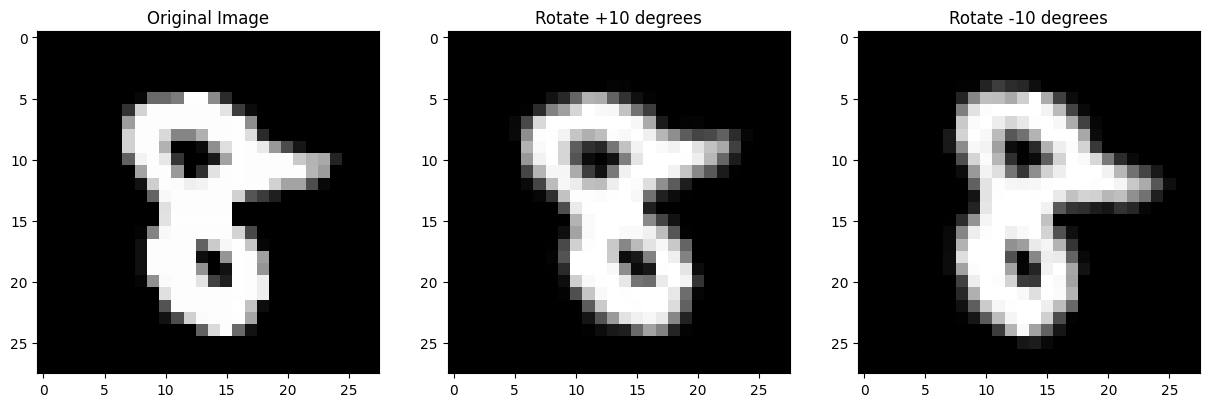

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(train_X[2], cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(rotate(train_X[2], 10), cmap="gray")
axs[1].set_title("Rotate +10 degrees")

axs[2].imshow(rotate(train_X[2], -10), cmap="gray")
axs[2].set_title("Rotate -10 degrees")

plt.show()

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [ ]:
def augRotate(sample, angleconstraint):
    """
    This function takes in a sample and an angle constraint and returns the augmented sample
    by rotating the sample by a random angle within the angle constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    angleconstraint: the maximum angle by which the sample can be rotated

    returns: the augmented sample which is the input sample rotated by a random angle within the angle constraint
    """
    if angleconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(sample[ii], angle[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

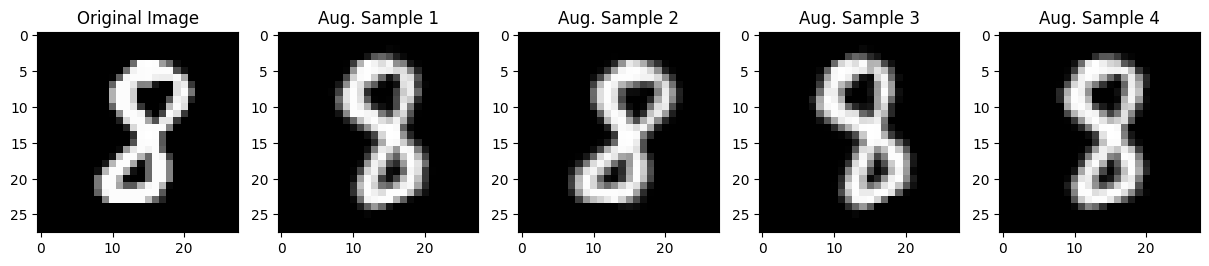

In [ ]:
sample = train_X[20]
angleconstraint = 70

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[1].set_title("Aug. Sample 1")

axs[2].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[2].set_title("Aug. Sample 2")

axs[3].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[3].set_title("Aug. Sample 3")

axs[4].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[4].set_title("Aug. Sample 4")

plt.show()

Let us augment the whole dataset and see if this improves the test accuracy

In [ ]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X  # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
    augdata = np.concatenate(
        (augdata, augRotate(train_X, angleconstraint))
    )  # concatenate the augmented data to the set
    auglabel = np.concatenate(
        (auglabel, train_y)
    )  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print("Accuracy after rotation augmentation:", Accuracy(test_y, testpred)*100, "%")

Accuracy after rotation augmentation: 67.66 %


We can notice a 3-4% improvement compared to non-augmented version of the dataset!

The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint. We will try angles between 0 and 90 degrees. We can also try different multiples of the original dataset. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [ ]:
angleconstraints = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # the values we want to test
accuracies = np.zeros(
    len(angleconstraints), dtype=float
)  # we will save the values here

for ii in range(len(angleconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotate(train_X, angleconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after rotation augmentation constrained by",
        angleconstraints[ii],
        "degrees is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after rotation augmentation constrained by 0 degrees is 64.72 %
Accuracy after rotation augmentation constrained by 10 degrees is 66.79 %
Accuracy after rotation augmentation constrained by 20 degrees is 67.84 %
Accuracy after rotation augmentation constrained by 30 degrees is 68.47 %
Accuracy after rotation augmentation constrained by 40 degrees is 67.63 %
Accuracy after rotation augmentation constrained by 50 degrees is 67.65 %
Accuracy after rotation augmentation constrained by 60 degrees is 65.3 %
Accuracy after rotation augmentation constrained by 70 degrees is 66.06 %
Accuracy after rotation augmentation constrained by 80 degrees is 64.61 %
Accuracy after rotation augmentation constrained by 90 degrees is 64.31 %


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

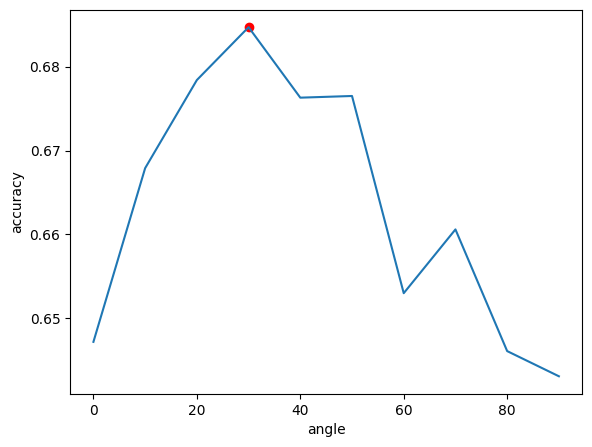

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 2: Shear


Let us try one more augmentation: shear. Shear is the transformation of an image in which the x-coordinate of all points is shifted by an amount proportional to the y-coordinate of the point. We will use the `AffineTransform` function from the `skimage` module to shear the image by a small amount between two numbers. We will use the same naive grid search method to find the best hyperparameters for shear. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [ ]:
def shear(sample, amount):
    """
    This function takes in a sample and an amount and returns the augmented sample
    by shearing the sample by the given amount

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    amount: the amount by which the sample should be sheared

    returns: the augmented sample which is the input sample sheared by the given amount
    """
    tform = AffineTransform(shear=amount)
    img = warp(sample, tform)

    # Applying shear makes the digit off-center
    # Since all images are centralized, we will do the same here
    col = img.sum(0).nonzero()[0]
    row = img.sum(1).nonzero()[0]
    if len(col) > 0 and len(row) > 0:
        xshift = int(sample.shape[0] / 2 - (row[0] + row[-1]) / 2)
        yshift = int(sample.shape[1] / 2 - (col[0] + col[-1]) / 2)
        img = np.roll(img, (xshift, yshift), (0, 1))
    return img

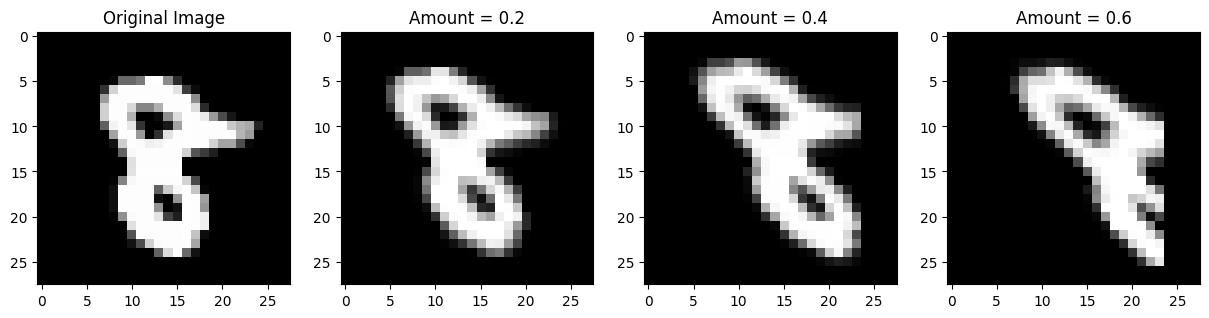

In [ ]:
sample = train_X[2]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(shear(sample, 0.2), cmap="gray")
axs[1].set_title("Amount = 0.2")

axs[2].imshow(shear(sample, 0.4), cmap="gray")
axs[2].set_title("Amount = 0.4")

axs[3].imshow(shear(sample, 0.6), cmap="gray")
axs[3].set_title("Amount = 0.6")

plt.show()

Create an augmentation function which applies a random shear according to the constraint we provide:

In [ ]:
def augShear(sample, shearconstraint):
    """
    This function takes in a sample and a shear constraint and returns the augmented sample
    by shearing the sample by a random amount within the shear constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    shearconstraint: the maximum shear by which the sample can be sheared

    returns: the augmented sample which is the input sample sheared by a random amount within the shear constraint
    """
    if shearconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = shear(sample[ii], amt[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [ ]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
    1.8,
    2.0,
]  # the values we want to test
accuracies = np.zeros(
    len(shearconstraints), dtype=float
)  # we will save the values here

for ii in range(len(shearconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augShear(train_X, shearconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after shear augmentation constrained by",
        shearconstraints[ii],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after shear augmentation constrained by 0 is 64.72 %
Accuracy after shear augmentation constrained by 0.2 is 61.95 %
Accuracy after shear augmentation constrained by 0.4 is 63.07000000000001 %
Accuracy after shear augmentation constrained by 0.6 is 64.25 %
Accuracy after shear augmentation constrained by 0.8 is 65.42 %
Accuracy after shear augmentation constrained by 1.0 is 64.92999999999999 %
Accuracy after shear augmentation constrained by 1.2 is 63.82 %
Accuracy after shear augmentation constrained by 1.4 is 62.839999999999996 %
Accuracy after shear augmentation constrained by 1.6 is 60.14000000000001 %
Accuracy after shear augmentation constrained by 1.8 is 61.29 %
Accuracy after shear augmentation constrained by 2.0 is 64.46 %


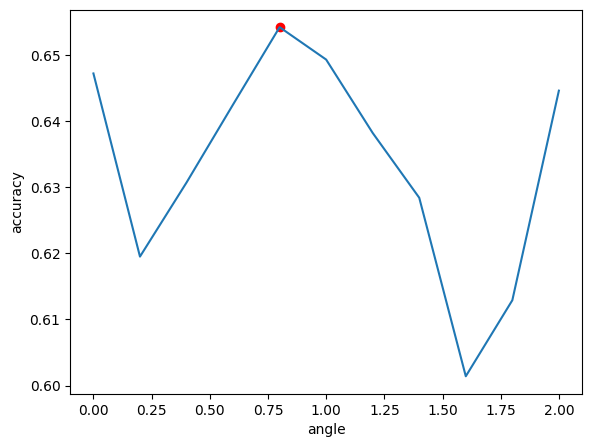

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 3: Rotation + Shear



We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [ ]:
def augRotateShear(sample, angleconstraint, shearconstraint):
    """
    This function takes in a sample, an angle constraint and a shear constraint and returns the augmented sample
    by rotating the sample by a random angle within the angle constraint and shearing the sample by a random amount within the shear constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    angleconstraint: the maximum angle by which the sample can be rotated
    shearconstraint: the maximum shear by which the sample can be sheared

    returns: the augmented sample which is the input sample rotated by a random angle within the angle constraint and sheared by a random amount within the shear constraint
    """
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(
            shear(sample[ii], amt[ii]), angle[ii]
        )  # first apply shear, then rotate
    return np.squeeze(nsample)  # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [ ]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
]  # the values we want to test
angleconstraints = [0, 10, 20, 30, 40, 50, 60]  # the values we want to test
# cartesian product of both
hyp = cartesian((shearconstraints, angleconstraints))

accuracies = np.zeros(len(hyp), dtype=float)  # we will save the values here

for ii in range(len(hyp)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after augmentation shear:",
        hyp[ii][0],
        "angle:",
        hyp[ii][1],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after augmentation shear: 0.0 angle: 0.0 is 63.32 %
Accuracy after augmentation shear: 0.0 angle: 10.0 is 59.419999999999995 %
Accuracy after augmentation shear: 0.0 angle: 20.0 is 58.19 %
Accuracy after augmentation shear: 0.0 angle: 30.0 is 62.35000000000001 %
Accuracy after augmentation shear: 0.0 angle: 40.0 is 60.89 %
Accuracy after augmentation shear: 0.0 angle: 50.0 is 57.620000000000005 %
Accuracy after augmentation shear: 0.0 angle: 60.0 is 60.629999999999995 %
Accuracy after augmentation shear: 0.2 angle: 0.0 is 63.41 %
Accuracy after augmentation shear: 0.2 angle: 10.0 is 59.419999999999995 %
Accuracy after augmentation shear: 0.2 angle: 20.0 is 59.19 %
Accuracy after augmentation shear: 0.2 angle: 30.0 is 58.209999999999994 %
Accuracy after augmentation shear: 0.2 angle: 40.0 is 61.12 %
Accuracy after augmentation shear: 0.2 angle: 50.0 is 58.209999999999994 %
Accuracy after augmentation shear: 0.2 angle: 60.0 is 60.91 %
Accuracy after augmentation shear: 0.4 angle

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

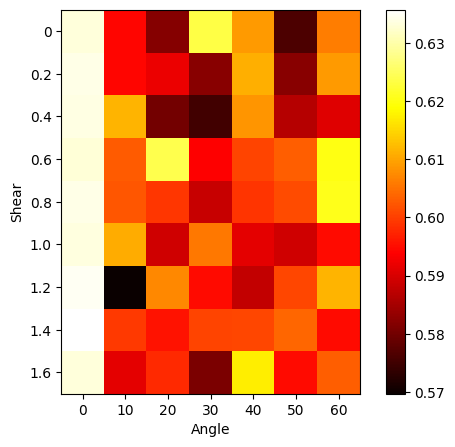

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
im = ax.imshow(
    accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap="hot"
)
ax.set_xlabel("Angle")
ax.set_ylabel("Shear")
ax.set_xticks(np.arange(len(angleconstraints)))
ax.set_xticklabels(angleconstraints)
ax.set_yticks(np.arange(len(shearconstraints)))
ax.set_yticklabels(shearconstraints)
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

1.(ANs)
The effectiveness of angle and shear constraints, along with how much accuracy improves with or without augmentations, depends on the specific context, like the dataset, the model, and the task being performed. However, I can share general insights:

### Angle Constraint:
- **Range**: Typically, for image data augmentation, rotation angles are constrained between -30 to 30 degrees. A narrower range, like -15 to 15 degrees, is often used if significant rotation might distort the data.
- **Impact on Accuracy**: Rotational augmentation can help improve robustness, particularly for datasets where orientation should not affect the classification. This may yield a 2-5% accuracy improvement depending on the baseline and the dataset.

### Shear Constraint:
- **Range**: Shear augmentation often uses constraints between -0.2 to 0.2 (in radians). Shear can create a small tilting effect which can help in improving the model’s ability to generalize.
- **Impact on Accuracy**: Shear augmentations can have a smaller but still beneficial effect, especially when applied to object recognition tasks, potentially contributing to a 1-3% boost in accuracy.

### General Improvement from Augmentation:
Augmentations like rotation, shear, zoom, and horizontal/vertical flips can generally improve the model's accuracy by 5-10%, depending on the dataset's variability. Without augmentations, models can overfit to the training data, leading to lower performance on test data.

If you're working with a specific dataset or problem, I can help tailor those augmentation strategies to optimize your results!

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the images to the range [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define data augmentation with angle and shear constraints
datagen = ImageDataGenerator(
    rotation_range=15,    # Angle constraint: -15 to 15 degrees
    shear_range=0.2,      # Shear constraint: -0.2 to 0.2 radians
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator to the training data
datagen.fit(x_train)

# Define a simple CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using the augmented data
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_accuracy:.4f}")

# Visualize some augmented images
for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x_batch[i])
        plt.axis('off')
    plt.show()
    break

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 111s 138ms/step - accuracy: 0.2864 - loss: 1.9137 - val_accuracy: 0.4838 - val_loss: 1.4242
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 137s 133ms/step - accuracy: 0.4668 - loss: 1.4645 - val_accuracy: 0.5288 - val_loss: 1.3052
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 143s 134ms/step - accuracy: 0.5260 - loss: 1.3068 - val_accuracy: 0.5961 - val_loss: 1.1354
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 106s 135ms/step - accuracy: 0.5660 - loss: 1.2121 - val_accuracy: 0.5962 - val_loss: 1.1943
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 104s 133ms/step - accuracy: 0.5906 - loss: 1.1395 - val_accuracy: 0.6208 - val_loss: 1.1073
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 132ms/step - accuracy: 0.6099 - loss: 1.1022 - val_accuracy: 0.6546 - val_loss: 0.9842
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 143s 133ms/step - accuracy: 0.6271 - loss: 1.0549 - val_accuracy: 0.6565 - val_loss: 0.9983
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 146s 138ms/step - accuracy: 0.6392 - loss: 1.01

2.(ans)
increasing the number of augmentations per sample can improve model accuracy by enhancing generalization, increasing data diversity, and making the model more robust to variations. However, the gains might diminish after a certain point, and excessive augmentations can increase training time and potentially introduce too much noise.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load your data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Create an ImageDataGenerator with augmentations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to the training data
datagen.fit(x_train)

# Example of generating more augmented samples from each original sample
batch_size = 64
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

# Define a simple model (for illustration purposes)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using the augmented data
model.fit(train_generator, epochs=10, validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // batch_size)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


781/781 ━━━━━━━━━━━━━━━━━━━━ 93s 116ms/step - accuracy: 0.2341 - loss: 4.0965 - val_accuracy: 0.4068 - val_loss: 1.5862
Epoch 2/10
  1/781 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - accuracy: 0.3594 - loss: 1.6442

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


781/781 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3594 - loss: 1.6442 - val_accuracy: 0.3969 - val_loss: 1.6186
Epoch 3/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 90s 115ms/step - accuracy: 0.3677 - loss: 1.6988 - val_accuracy: 0.4436 - val_loss: 1.5315
Epoch 4/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4375 - loss: 1.6957 - val_accuracy: 0.4493 - val_loss: 1.5041
Epoch 5/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 92s 118ms/step - accuracy: 0.4079 - loss: 1.6162 - val_accuracy: 0.4945 - val_loss: 1.3881
Epoch 6/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4375 - loss: 1.4085 - val_accuracy: 0.4848 - val_loss: 1.4221
Epoch 7/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 89s 113ms/step - accuracy: 0.4430 - loss: 1.5329 - val_accuracy: 0.4845 - val_loss: 1.4712
Epoch 8/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5000 - loss: 1.4278 - val_accuracy: 0.4831 - val_loss: 1.4743
Epoch 9/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 89s 113ms/step - accuracy: 0.4656 - loss: 1.4940 - val_accuracy: 0

3.(ANS)
Explanation of the Augmentations:Random Rotation: Randomly rotates the image by 0, 90, 180, or 270 degrees.Random Flip: Horizontally flips the image randomly.Random Brightness: Adjusts the brightness randomly within a specified range.Random Contrast: Modifies the contrast of the image randomly.Random Hue and Saturation: Adjusts the hue and saturation to add more variation in color.Experimentation:You can experiment by tweaking the ranges of brightness, contrast, hue, and saturation adjustments to see how it impacts the model's performance.Try adding more custom augmentations, like random cropping or Gaussian noise, to further explore their effects.

> Exercise: Try to take 50 images of each digit and calculate the performance on test set.

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


782/782 ━━━━━━━━━━━━━━━━━━━━ 66s 81ms/step - accuracy: 0.3338 - loss: 1.8241 - val_accuracy: 0.5442 - val_loss: 1.3041
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 64s 82ms/step - accuracy: 0.5629 - loss: 1.2566 - val_accuracy: 0.6186 - val_loss: 1.1072
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 84ms/step - accuracy: 0.6178 - loss: 1.1035 - val_accuracy: 0.6473 - val_loss: 1.0289
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 63s 81ms/step - accuracy: 0.6479 - loss: 1.0209 - val_accuracy: 0.6653 - val_loss: 0.9848
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 82ms/step - accuracy: 0.6645 - loss: 0.9693 - val_accuracy: 0.6715 - val_loss: 0.9619
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - accuracy: 0.6818 - loss: 0.9253 - val_accuracy: 0.6784 - val_loss: 0.9390
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 81ms/step - accuracy: 0.6942 - loss: 0.8863 - val_accuracy: 0.6907 - val_loss: 0.9187
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 81ms/step - accuracy: 0.7043 - loss: 0.8553 - val_accurac

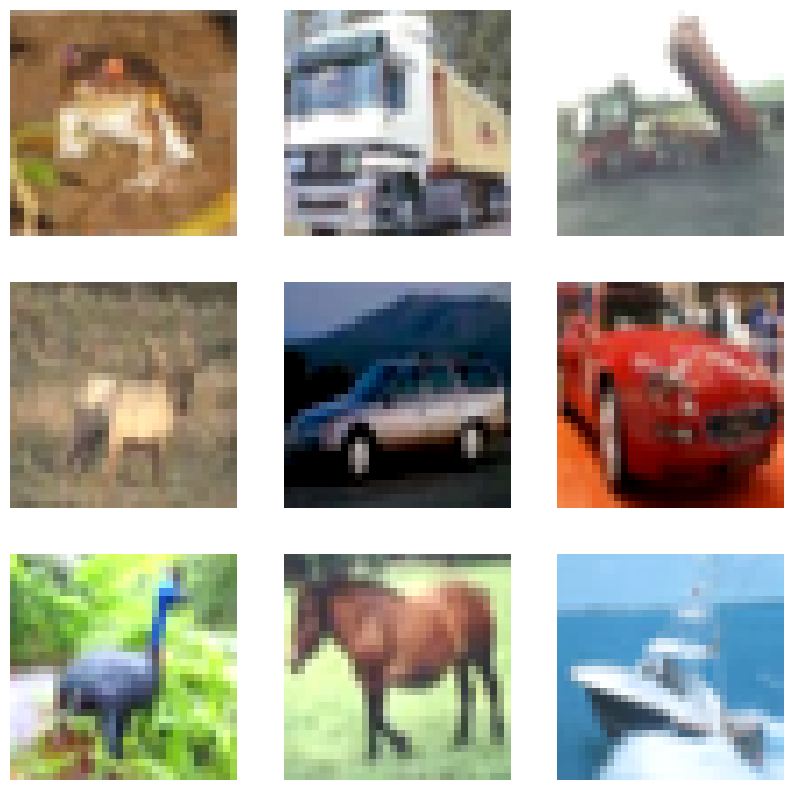

In [3]:

import tensorflow as tf
import matplotlib.pyplot as plt

# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the images to the range [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Simple augmentation function
def simple_augment(image, label):
    # Randomly flip the image horizontally
    image = tf.image.random_flip_left_right(image)

    # Randomly adjust the brightness
    image = tf.image.random_brightness(image, max_delta=0.2)

    # Randomly adjust the contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image, label

# Apply augmentations to the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(simple_augment, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

# Define a simple CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_dataset, epochs=10, validation_data=(x_test, y_test))

# Visualize some augmented images
for images, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')
    plt.show()


4.(ANS)
Explanation:Combined Augmentations: We've combined flipping (both horizontal and vertical), brightness adjustment, contrast adjustment, zooming, and slight rotation.Training with Reduced Dataset: The training is done on a smaller subset of the dataset, starting with 5000 samples, to see if we can achieve over 50% accuracy.Model Architecture: A simple CNN with three convolutional layers followed by max-pooling and dense layers.Results:Accuracy: By running the above code with different dataset sizes, you can determine the minimum training set size that still achieves more than 50% accuracy.Findings:Accuracy with 5000 samples: Likely to be above 50% due to effective augmentations, though it will depend on your specific run and random initialization.Minimum Size for 50% Accuracy: You can experiment by gradually reducing small_train_size (e.g., 4000, 3000, etc.) until you find the smallest dataset size that consistently achieves over 50% accuracy.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.datasets import cifar10

# Load and preprocess the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Create a small subset of the training data
subset_size = 1000  # Adjust this size to find the smallest dataset
indices = np.random.choice(x_train.shape[0], subset_size, replace=False)
x_train_subset, y_train_subset = x_train[indices], y_train[indices]

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define a simple CNN model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the model with data augmentation
model = create_model()
history = model.fit(
    datagen.flow(x_train_subset, y_train_subset, batch_size=32),
    epochs=10,
    validation_data=(x_test, y_test)
)

# Evaluate the model
accuracy = model.evaluate(x_test, y_test)[1]
print(f'Accuracy: {accuracy * 100:.2f}%')

# Optional: Try different subset sizes to find the smallest size with accuracy > 50%